# Recommendation system colaborative filtering with LightGCN

Since there is no open dataset for music recommendation, we can only use movie lens dataset

### Import stuff

Download

In [1]:
# import torch

# !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install git+https://github.com/pyg-team/pytorch_geometric.git
# !pip install torch_geometric
# !pip install tensorly

Import library

In [2]:
import collections
import math
import os
import os.path as osp
from tqdm import tqdm
from typing import List
import random
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_rows = 10
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorly import decomposition

import torch
from torch.functional import tensordot
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim, Tensor
import torch_geometric
from torch_geometric.data import Dataset, Data, download_url, extract_zip
from torch_geometric.nn import MessagePassing
from torch_geometric.typing import Adj

Some config for the dataset

In [3]:
config_dict = {
    "sample_per_user":400,
    "num_user":500,

    "epochs": 100,
    "batch_size": 256,
    "lr": 0.0005,
    "weight_decay": 0.05,

    "embedding_size": 64,
    "num_layers": 8,
    "K": 10,
    "mf_rank": 8,
}

## Dataset

In [4]:
DATA_PATH = "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
DOWNLOAD = "download"
DIRECTORY = "data"

In [5]:
download_url(DATA_PATH, DOWNLOAD)

Using existing file ml-1m.zip


'download\\ml-1m.zip'

In [6]:
import os
os.getcwd()

'f:\\code\\rcm\\recommend-gnn\\colaborative'

In [7]:
with zipfile.ZipFile(DOWNLOAD+"/ml-1m.zip", 'r') as zip_ref:
    zip_ref.extractall(DIRECTORY)

user_col = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table(DIRECTORY +'/ml-1m/users.dat',
                      sep='::', header=None, names=user_col,
                      engine='python', encoding='latin-1')

rating_col = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table(DIRECTORY +'/ml-1m/ratings.dat',
                      sep='::', header=None, names=rating_col,
                      engine='python', encoding='latin-1')

movie_col = ['movie_id', 'title', 'geners']
movies = pd.read_table(DIRECTORY +'/ml-1m/movies.dat',
                      sep='::', header=None, names=movie_col,
                      engine='python', encoding='latin-1')


In [8]:
len(users['user_id'].unique()),len(movies['movie_id'].unique())

(6040, 3883)

In [9]:
users.head()

,user_id,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [10]:
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [11]:
movies.head()

,movie_id,title,geners
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


### Process the data
convert them into graph haha

In [12]:
user = users['user_id']
movie = movies['movie_id']

num_users = config_dict['num_user']


if num_users != -1:
    user = user[:num_users]

user_ids  = range(len(users))
movie_ids = range(len(movies))

user_to_id  = dict(zip(user, user_ids))
movie_to_id = dict(zip(movie, movie_ids))

num_user = user.shape[0]
num_item = movie.shape[0]

rate_matrix = torch.zeros(num_user,num_item)

for i, row in ratings.iterrows():
    u, m, r = row[:3]
    if num_users != -1:
        if u not in user_to_id:
            break

    rate_matrix[user_to_id[u], movie_to_id[m]] = r

data = Data(edge_index = rate_matrix,
            raw_edge_index = rate_matrix.clone(),
            data = ratings,
            users = user,
            items = movie)

In [13]:
data

Data(edge_index=[500, 3883], raw_edge_index=[500, 3883], data=         user_id  movie_id  rating  timestamp
0              1      1193       5  978300760
1              1       661       3  978302109
2              1       914       3  978301968
3              1      3408       4  978300275
4              1      2355       5  978824291
...          ...       ...     ...        ...
1000204     6040      1091       1  956716541
1000205     6040      1094       5  956704887
1000206     6040       562       5  956704746
1000207     6040      1096       4  956715648
1000208     6040      1097       4  956715569

[1000209 rows x 4 columns], users=0        1
1        2
2        3
3        4
4        5
      ... 
495    496
496    497
497    498
498    499
499    500
Name: user_id, Length: 500, dtype: int64, items=0          1
1          2
2          3
3          4
4          5
        ... 
3878    3948
3879    3949
3880    3950
3881    3951
3882    3952
Name: movie_id, Length: 3883, dtype: in

In [14]:
def trans_ml(dat, thres):
    """
    Transform function that assign non-negative entries >= thres 1, and non-
    negative entries <= thres 0. Keep other entries the same.
    """
    matrix = dat['edge_index']
    matrix[(matrix < thres) & (matrix > -1)] = 0
    matrix[(matrix >= thres)] = 1
    dat['edge_index'] = matrix
    return dat

In [15]:
data = trans_ml(data, 3)

## Train test split

So far

Training mask will mask train part dataset 1 and testing+ val =0

Validating mask will mask val part of dataset 1 an the rest 0

Testing mask will mask all dataset 1

In [16]:
VAL_FRAC = 0.2
TEST_FRAC = 0.1

num_users = num_user
num_items = num_item

num_train_replaced = round(num_users*num_items*(VAL_FRAC+TEST_FRAC))
num_val_show = round(num_users*num_items*VAL_FRAC)

indices_user = np.random.randint(0, num_users, num_train_replaced)
indices_item = np.random.randint(0, num_items, num_train_replaced)

indices_val_user = np.random.randint(0, num_users, num_val_show)
indices_val_item = np.random.randint(0, num_items, num_val_show)

train_mask = torch.ones(num_users, num_items, dtype=torch.bool)
train_mask[indices_user, indices_item] = False

val_mask = torch.zeros(num_users, num_items, dtype=torch.bool)
val_mask[indices_val_user, indices_val_item] = True

test_mask = torch.ones_like(train_mask)

In [17]:
train_mask

tensor([[False,  True, False,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False, False],
        [ True,  True,  True,  ...,  True, False,  True],
        ...,
        [ True, False,  True,  ..., False,  True,  True],
        [False,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ..., False, False,  True]])

In [18]:
def sample_pos_neg(data, mask, num_samples):
    sample = []
    all_items = set(range(len(data['items'])))

    for user_index, user in enumerate(data['users']):
        pos_items = set(
            torch.nonzero(data['edge_index'][user_index])[:,0].tolist()
        )

        unknown_items = all_items.difference(set(
            torch.nonzero(data['raw_edge_index'][user_index])[:,0].tolist()
        ))

        neg_items = all_items.difference(pos_items).difference(unknown_items)

        unmasked_items = set(torch.nonzero(mask[user_index])[:,0].tolist())

        if len(unknown_items.union(pos_items)) == 0 or len(unknown_items.union(neg_items)) == 0:
            continue

        if len(pos_items.intersection(unmasked_items)) == 0:
            post_items_indexs = np.random.choice(
                list(unknown_items.intersection(unmasked_items)), num_samples
            )
        else:
            post_items_indexs = np.random.choice(
                list(pos_items.intersection(unmasked_items)), num_samples
            )

        if len(neg_items.intersection(unmasked_items)) == 0:
            neg_items_indexs = np.random.choice(
                list(unknown_items.intersection(unmasked_items)), num_samples
            )
        else:
            neg_items_indexs = np.random.choice(
                list(neg_items.intersection(unmasked_items)), num_samples
            )
        user_indexs = np.array([user_index]*num_samples)
        sample.append(torch.tensor(np.vstack([user_indexs, post_items_indexs, neg_items_indexs]), dtype=torch.int32))

    return torch.cat(sample, dim=1).T


In [19]:
train_samples = sample_pos_neg(data, train_mask, config_dict['sample_per_user'])
val_samples = sample_pos_neg(data, val_mask, config_dict['sample_per_user'])
test_samples = sample_pos_neg(data, test_mask, config_dict['sample_per_user'])

In [20]:
train_samples.shape

torch.Size([200000, 3])

## LightGCN
[paper](https://arxiv.org/abs/2002.02126)

### LightGCN Convolution Layers

In [21]:
class LightGCNConv(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int,
                 num_users: int, num_items: int, **kwargs):
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.num_users = num_users
        self.num_items = num_items

        self.reset_parameters()

    def reset_parameters(self):
        pass

    def forward(self, x, edge_index):
        user_item = torch.zeros(self.num_users, self.num_items, device = x.device)
        user_item[edge_index[:,0], edge_index[:,1]] = 1

        tol_user = torch.sum(user_item, axis=1)
        tol_item = torch.sum(user_item, axis=0)

        weights = user_item / torch.sqrt(
            tol_user.repeat(self.num_items, 1).T * tol_item.repeat(self.num_users, 1)
        )

        weights = torch.nan_to_num(weights, nan=0.0)

        out = torch.concat((
            weights.T @ x[:self.num_users],
            weights @ x[self.num_users:]
        ),dim=0)
        return out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

### LightGCN

In [22]:
class LightGCN(nn.Module):
    def __init__(self,config: dict, **kwargs):
        super().__init__()

        self.config = config

        self.num_users  = config["n_users"]
        self.num_items  = config["m_items"]
        self.embedding_size = config["embedding_size"]
        self.in_channels = self.embedding_size
        self.out_channels = self.embedding_size
        self.num_layers = config["num_layers"]

        # 0-th Embedding layer (E_0), the only training parameter here
        self.embedding_user_item = torch.nn.Embedding(
            num_embeddings=self.num_users + self.num_items,
            embedding_dim=self.embedding_size)
        self.alpha = None

        nn.init.normal_(self.embedding_user_item.weight, std=0.1)

        self.f = nn.Sigmoid()
        self.convs = nn.ModuleList()

        self.convs.append(LightGCNConv(self.in_channels, self.out_channels, self.num_users, self.num_items, **kwargs))

        for _ in range(1, self.num_layers):
            self.convs.append(LightGCNConv(self.in_channels, self.out_channels, self.num_users, self.num_items, **kwargs))

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, edge_index):

        xs = []

        edge_index = torch.nonzero(edge_index)

        for conv in self.convs:
            x = conv(x, edge_index)
            xs.append(x)

        xs = torch.stack(xs)

        self.alpha = 1 / (self.num_layers + 1)*torch.ones(xs.shape, device=self.device)
        x = torch.sum(self.alpha*xs, dim=0)

        return x

### Ultility func

In [23]:
def getUsersRating(model, users, data):
    """ Get the embedding of users

    """
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"])
    all_users = all_users_items[:len(data["users"])]
    items_emb = all_users_items[len(data["users"]):]
    users_emb = all_users[users.long()]
    rating = model.f(torch.matmul(users_emb, items_emb.T))

    return rating

def getEmbedding(model, users, pos, neg, data, mask):

    # assuming we always search for users and items by their indices (instead of
    # user/item number)
    all_users_items = model(model.embedding_user_item.weight.clone(),
                            data["edge_index"] * mask)
    all_users = all_users_items[:len(data["users"])]
    all_items = all_users_items[len(data["users"]):]
    users_emb = all_users[users]
    pos_emb = all_items[pos]
    neg_emb = all_items[neg]
    n_user = len(data["users"])
    users_emb_ego = model.embedding_user_item(users)
    # offset the index to fetch embedding from user_item
    pos_emb_ego = model.embedding_user_item(pos + n_user)
    neg_emb_ego = model.embedding_user_item(neg + n_user)
    return users_emb, pos_emb, neg_emb, users_emb_ego, pos_emb_ego, neg_emb_ego

### Loss function BPR

$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$

In [24]:
def BPR_loss(model, inp_users, inp_pos, inp_neg, inp_data, inp_mask, lamda=0.05):
    assert len(inp_users) == len(inp_pos) and len(inp_users) == len(inp_neg)
    (users_emb, pos_emb, neg_emb, users_emb0,  pos_emb0, neg_emb0) = getEmbedding(model, inp_users.long(), inp_pos.long(),
                                                inp_neg.long(), inp_data, inp_mask)
    l2_loss = lamda*(torch.norm(users_emb0)**2 + torch.norm(pos_emb0)**2 + torch.norm(neg_emb0)**2)/float(len(users))

    pos_score = torch.sum(users_emb*pos_emb, dim=1)
    neg_score = torch.sum(users_emb*neg_emb, dim=1)

    loss = -torch.mean(torch.log(torch.sigmoid(pos_score - neg_score))) + l2_loss

    return loss

In [25]:
def personalized_topk(pred, K, user_indices, edge_index):
    # Rewrite this

    per_user_preds = collections.defaultdict(list)
    for index, user in enumerate(user_indices):
        per_user_preds[user.item()].append(pred[index].item())
    precisions = 0.0
    recalls = 0.0
    for user, preds in per_user_preds.items():
        K = min(len(preds),K)
        # while len(preds) < K:
        #     preds.append(random.choice(range(edge_index.shape[1])))
        top_ratings, top_items = torch.topk(torch.tensor(preds), K)
        correct_preds = edge_index[user, top_items].sum().item()
        total_pos = edge_index[user].sum().item()
        precisions += correct_preds / K
        recalls += correct_preds / total_pos if total_pos != 0 else 0
    num_users = len(user_indices.unique())
    return precisions / num_users, recalls / num_users

In [26]:
def metric_topk_2(pred,K,edge_index):
    topk_ratings, top_k_items = pred.topk(K, dim=1)
    topk_pred = torch.zeros_like(pred)
    topk_pred.scatter_(1, top_k_items, 1)
    
    precision = (topk_pred * edge_index).sum() / (K * edge_index.shape[0])
    recall = (topk_pred * edge_index).sum() / edge_index.sum()
    return precision, recall

## Training

In [27]:
num_samples_per_user = config_dict["sample_per_user"]
epochs = config_dict["epochs"]
batch_size = config_dict["batch_size"]
lr = config_dict["lr"]
weight_decay = config_dict["weight_decay"]
K = config_dict["K"]

n_users = len(data["users"].unique())
m_items = len(data["items"].unique())

model_config = {
    "n_users": n_users,
    "m_items": m_items,
    "embedding_size": config_dict["embedding_size"],
    "num_layers": config_dict["num_layers"],
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lightGCN = LightGCN(model_config)
lightGCN.to(device)

optimizer = torch.optim.Adam(lightGCN.parameters(), lr=lr)
model_config

{'n_users': 500, 'm_items': 3883, 'embedding_size': 64, 'num_layers': 8}

In [28]:
samples_train=train_samples.to(device)
samples_val=val_samples.to(device)
samples_test=val_samples.to(device)
train_mask=train_mask.to(device)
val_mask=val_mask.to(device)
test_mask=test_mask.to(device)
data = data.to(device)

In [29]:
samples_train.shape

torch.Size([200000, 3])

In [30]:
def batch_dataloader(dataset):
    dataset = dataset.to(device)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_dataloader = batch_dataloader(samples_train)
val_dataloader = batch_dataloader(samples_val)
test_dataloader = batch_dataloader(samples_test)

In [31]:
epochs_tracked=[]
val_topks=[]

In [32]:
all_users = torch.linspace(start=0, end=n_users - 1, steps=n_users).long()
for epoch in range(epochs):
    lightGCN.train()
    loss_sum = 0
    for batch in tqdm(train_dataloader, desc="Training epoch "+str(epoch)):
        optimizer.zero_grad()

        user = batch[:,0:1]
        pos = batch[:,1:2]
        neg = batch[:,2:3]

        loss = BPR_loss(lightGCN, user, pos, neg, data, train_mask, weight_decay)

        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    loss_sum/=len(train_dataloader)

    epochs_tracked.append(epoch)
    lightGCN.eval()
    loss_test = 0
    # precisions = 0
    # recalls = 0
    
    if epoch % 10 == 0:
        with torch.no_grad():
            all_guess = getUsersRating(lightGCN, all_users, data)
            users_index = samples_val[:,0]
            for batch in tqdm(val_dataloader):
                users_val = batch[:, 0:1]
                pos_val = batch[:, 1:2]
                neg_val = batch[:, 2:3]

                loss_t = BPR_loss(lightGCN, users_val, pos_val, neg_val, data, val_mask)
                loss_test+=loss_t.item()
                # predict on the validation set
            user_indices = samples_val[:, 0]
                
                # Getting both positive and negative items
            user_indices = user_indices.repeat(2).long()
            item_indices = torch.cat((samples_val[:, 1], samples_val[:, 2])).long()

            pred_val = all_guess[user_indices, item_indices]
            
            precision, recall = metric_topk_2(all_guess, K, data["edge_index"])


            val_topks.append((precision, recall))

            num_users = len(user_indices.unique())
            loss_test/=len(val_dataloader)

            print(f"Epoch {epoch} BPR_train Loss: {loss_sum},\n Validation: BPR_val Loss: {loss_test} TopK Precision: {round(float(precision),6)}, TopK Recall: {round(float(recall),6)}")


100%|██████████| 782/782 [00:02<00:00, 286.67it/s]


Epoch 0 BPR_train Loss: 0.6944278825426955,
 Validation: BPR_val Loss: 0.693537088535021 TopK Precision: 0.035, TopK Recall: 0.002806


100%|██████████| 782/782 [00:02<00:00, 291.18it/s]


Epoch 10 BPR_train Loss: 0.6931475315557416,
 Validation: BPR_val Loss: 0.6931526656345943 TopK Precision: 0.0856, TopK Recall: 0.006862


100%|██████████| 782/782 [00:02<00:00, 287.65it/s]


Epoch 20 BPR_train Loss: 0.6931471898580146,
 Validation: BPR_val Loss: 0.693150284573855 TopK Precision: 0.0856, TopK Recall: 0.006862


100%|██████████| 782/782 [00:02<00:00, 288.59it/s]


Epoch 30 BPR_train Loss: 0.6931471825408204,
 Validation: BPR_val Loss: 0.6931502005785627 TopK Precision: 0.0856, TopK Recall: 0.006862


100%|██████████| 782/782 [00:02<00:00, 288.11it/s]


Epoch 40 BPR_train Loss: 0.6931471824645996,
 Validation: BPR_val Loss: 0.6931501985968226 TopK Precision: 0.0856, TopK Recall: 0.006862


100%|██████████| 782/782 [00:02<00:00, 295.17it/s]


Epoch 50 BPR_train Loss: 0.6931471824645996,
 Validation: BPR_val Loss: 0.693150198825485 TopK Precision: 0.0856, TopK Recall: 0.006862


Training epoch 57:  41%|████      | 317/782 [00:01<00:02, 167.21it/s]


KeyboardInterrupt: 

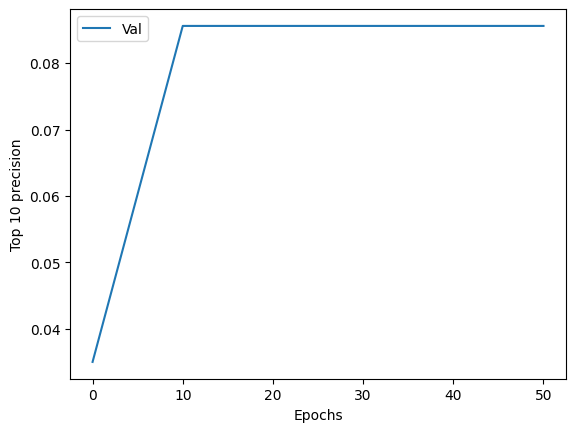

In [37]:
plt.plot([0,10,20,30,40,50], [precision.item() for precision, _ in val_topks],
         label="Val")
plt.ylabel(f"Top {K} precision")
plt.xlabel("Epochs")
plt.legend()
plt.show()

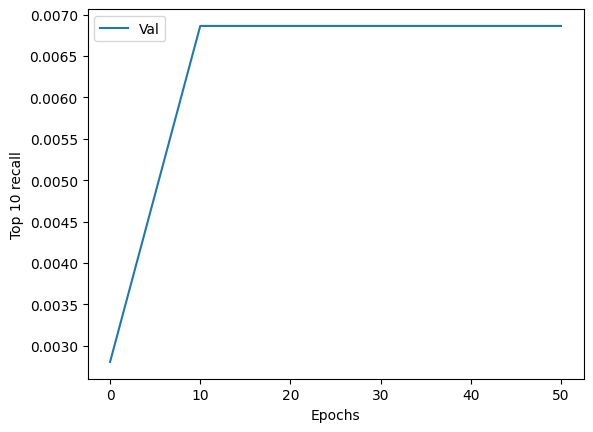

In [39]:
plt.plot([0,10,20,30,40,50], [recall.item() for _, recall in val_topks],
         label="Val")
plt.ylabel(f"Top {K} recall")
plt.xlabel("Epochs")
plt.legend()
plt.show()